Importing Essential Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Machine Learning Libraries (Part 1)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

print("Libraries imported successfully.")

Libraries imported successfully.


Loading datasets

In [40]:
# Load the Processed Data
print("Loading processed data...")

# 1. Load Training Data
train_df = pd.read_csv('processed_data/train_processed.csv', index_col=0)
# Split back into X and y
y_train = np.log1p(train_df['price'])
X_train = train_df.drop(columns=['price'])

# 2. Load Internal Validation Data
val_df = pd.read_csv('processed_data/val_processed.csv', index_col=0)
# Split back into X and y
y_test = np.log1p(val_df['price'])
X_test = val_df.drop(columns=['price'])

# 3. Load External Submission Data (No 'price' column here)
X_submission = pd.read_csv('processed_data/submission_processed.csv', index_col=0)

print(" Data Loaded Successfully.")
print(f"Training Set:   X={X_train.shape}, y={y_train.shape}")
print(f"Validation Set: X={X_test.shape},  y={y_test.shape}")
print(f"Submission Set: X={X_submission.shape}")

Loading processed data...
 Data Loaded Successfully.
Training Set:   X=(12967, 16), y=(12967,)
Validation Set: X=(3242, 16),  y=(3242,)
Submission Set: X=(5404, 20)


Training Random Forest Model (Part 1)

In [57]:
print("--- PART 1: TABULAR BASELINE (Random Forest) ---")

# 1. Initialize
rf_model = RandomForestRegressor(n_estimators=100,max_depth=None,bootstrap=True,oob_score=True,random_state=42)

# 2. Train
print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# 3. Predict & Evaluate
y_pred_rf = rf_model.predict(X_test)

rf_r2 = r2_score(np.expm1(y_test), np.expm1(y_pred_rf))
rf_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_rf)))

print(" Random Forest Results:")
print("R² Score: ",rf_r2)
print("RMSE: ",rf_rmse)

--- PART 1: TABULAR BASELINE (Random Forest) ---
Training Random Forest...
 Random Forest Results:
R² Score:  0.8479170146664853
RMSE:  138147.32165293954


Block 1: Defines the MultimodalDataGenerator to handle image and tabular data loading ( Custom Data Generator Class)

In [58]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras import models, layers, optimizers

os.environ["TF_USE_LEGACY_KERAS"] = "1"

print(f"TensorFlow Version: {tf.__version__}")

class MultimodalDataGenerator(Sequence):
    """
    Custom Data Generator for Hybrid AI.
    Loads data in batches (e.g., 32 at a time) to prevent RAM crashes.
    Inputs: 
        1. House Images (Satellite view)
        2. Tabular Data (Bedrooms, Sqft, etc.)
    Output:
        1. Price (Target)
    """
    def __init__(self, df, x_col, y_col, image_dir, batch_size=32, target_size=(224, 224), shuffle=True):
        self.df = df.copy()         # Work on a copy to avoid modifying original data
        self.x_col = x_col          # Column name for House ID (index)
        self.y_col = y_col          # Column name for Price (Target)
        self.image_dir = image_dir  # Path to 'house_images' folder
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        
        # Create a list of indices (0 to N) to track rows
        self.indices = np.arange(len(self.df))
        
        # Shuffle immediately upon starting
        self.on_epoch_end()

    def __len__(self):
        """Calculates the number of batches per epoch."""
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch of data."""
        # 1. Select the indices for this batch (e.g., rows 0 to 32)
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # 2. Find the House IDs for these rows
        batch_ids = [self.df.index[k] for k in indices]

        # 3. Generate data
        X, y = self.__data_generation(batch_ids, indices)
        return X, y

    def on_epoch_end(self):
        """Shuffles data after every epoch so the model doesn't memorize order."""
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_ids, batch_indices):
        """Loads the images and numbers for the specific batch."""
        
        # --- PART A: LOAD IMAGES ---
        images = []
        for house_id in batch_ids:
            img_path = os.path.join(self.image_dir, f"{house_id}.jpg")
            
            # Safety Check: If image didn't download, use a black placeholder
            if os.path.exists(img_path):
                try:
                    img = load_img(img_path, target_size=self.target_size)
                    img = img_to_array(img)
                    img = img / 255.0  # Normalize (0-255 -> 0-1)
                except:
                    # If image is corrupt
                    img = np.zeros((self.target_size[0], self.target_size[1], 3))
            else:
                # If image is missing
                img = np.zeros((self.target_size[0], self.target_size[1], 3))
            
            images.append(img)
        
        
        
    
       
        images = np.array(images, dtype=np.float32)
        
        if self.y_col and self.y_col in self.df.columns:
            tabular = self.df.iloc[batch_indices].drop(columns=[self.y_col]).values
        else:
            # This line is critical! It defines 'tabular' for prediction mode
            tabular = self.df.iloc[batch_indices].values
        
        tabular = np.array(tabular, dtype=np.float32)
        
        
        if self.y_col and self.y_col in self.df.columns:
            # Training Mode:  TUPLE 
            y = self.df.iloc[batch_indices][self.y_col].values
            return (images, tabular), y
        else:
            # Prediction Mode: A LIST 
            return [images, tabular]
        
        

        

TensorFlow Version: 2.20.0


Block 2:Sets up train_gen and val_gen with the correct batch size and image folders(Initialize Generators)

In [59]:
# --- BLOCK 2: INITIALIZE GENERATORS ---

# 1. Configuration
IMAGE_FOLDER = 'house_images'  # Must match the folder name where images are downloading
BATCH_SIZE = 32               # Process 32 houses at a time
IMAGE_SIZE = (224, 224)        # The standard size that AI models prefer

print("Preparing Data Generators...")

# 2. Re-combine X and y for the Generator
# The generator expects one single dataframe so it can shuffle X and y together securely.
train_full = pd.concat([X_train, y_train], axis=1)
val_full = pd.concat([X_test, y_test], axis=1)

train_full['id'] = train_full.index
val_full['id'] = val_full.index

# 3. Create the Training Generator
train_gen = MultimodalDataGenerator(
    df=train_full,
    x_col='id',       # Uses the Index (House ID) to find the image
    y_col='price',    # The target value we are predicting
    image_dir=IMAGE_FOLDER,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    shuffle=True      # True: Mixes up data so the model learns better
)

# 4. Create the Validation Generator
val_gen = MultimodalDataGenerator(
    df=val_full,
    x_col='id',
    y_col='price',
    image_dir=IMAGE_FOLDER,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    shuffle=False     # False: Keep order stable for accurate scoring
)

print(f" Generators Ready!")
print(f" - Training Batches per Epoch: {len(train_gen)}")
print(f" - Validation Batches per Epoch: {len(val_gen)}")

Preparing Data Generators...
 Generators Ready!
 - Training Batches per Epoch: 405
 - Validation Batches per Epoch: 101


Block 3:Constructs the model architecture using EfficientNetB0 for images and Dense layers for tabular data(Build Hybrid Neural Network)

In [60]:
# --- BLOCK 3: BUILD HYBRID MODEL ---
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, concatenate

# Clear memory
tf.keras.backend.clear_session()

def build_hybrid_model(tabular_shape=16):
    # --- BRANCH 1: IMAGE ---
    # CHANGED: input_shape to (224, 224 3) for speed
    base_cnn = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    base_cnn.trainable = False 
    for layer in base_cnn.layers[:]: 
        layer.trainable = False
        
    # Image Input
    # CHANGED: input_shape to (224, 224, 3)
    image_input = tf.keras.layers.Input(shape=(224, 224, 3), name='image_input')
    x_img = base_cnn(image_input)
    x_img = GlobalAveragePooling2D()(x_img)
    x_img = Dense(256, activation='relu')(x_img)
    x_img = (x_img)
    
    # --- BRANCH 2: TABULAR ---
    tabular_input = tf.keras.layers.Input(shape=(tabular_shape,), name='tabular_input')
    x_tab = Dense(64, activation='relu')(tabular_input)

    x_tab = Dense(32, activation='relu')(x_tab)
    
    # --- COMBINED ---
    combined = concatenate([x_img, x_tab])
    x = Dense(128, activation='relu')(combined)
    
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='linear', name='price_output')(x)
    
    # Build Model
    model = models.Model(inputs=[image_input, tabular_input], outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
    
    return model

# Create the model
hybrid_model = build_hybrid_model(tabular_shape=16)
print(" Model created successfully. ")

 Model created successfully. 


Block 4: Runs the training loop with Callbacks for Checkpointing, Early Stopping, and Learning Rate Reduction(Train the model)

In [61]:
# ----Block 4---- 
# The training loop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- Training Configuration ---
checkpoint = ModelCheckpoint(
    filepath='best_hybrid_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

print("Starting training process...")

# --- DATA PIPELINE OPTIMIZATION ---
def create_tf_dataset(generator, input_signature):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=input_signature
    )
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Define signatures (MUST MATCH THE 128x128 MODEL)
signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32), # Image (128)
        tf.TensorSpec(shape=(None, 16), dtype=tf.float32)           # Tabular
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)                  # Price
)

print("Optimizing Data Pipeline...")
try:
    fast_train_gen = create_tf_dataset(train_gen, signature).repeat()
    fast_val_gen = create_tf_dataset(val_gen, signature).repeat()
    train_steps = len(train_gen) 
    val_steps = len(val_gen)
    print("Pipeline Optimized for Speed. 🚀")
except Exception as e:
    print("Error optimizing pipeline. Ensure Block 2 generator target_size is (128,128).")
    print(e)

# Train
history = hybrid_model.fit(
    fast_train_gen,
    validation_data=fast_val_gen,
    epochs=20,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    steps_per_epoch=train_steps,  # Explicitly tell Keras when an epoch ends
    validation_steps=val_steps,   # Explicitly tell Keras how much to validate
    verbose=1
)

print("Training finished.")

Starting training process...
Optimizing Data Pipeline...
Pipeline Optimized for Speed. 🚀
Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
TypeError: `generator` yielded an element of shape (32, 17) where an element of shape (None, 16) was expected.
Traceback (most recent call last):

  File "c:\Users\navya\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)

  File "c:\Users\navya\anaconda3\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "c:\Users\navya\anaconda3\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 235, in generator_py_func
    raise TypeError(
        f"`generator` yielded an element of shape {ret_array.shape} "
        f"where an element of shape {expected_shape} was expected.")

TypeError: `generator` yielded an element of shape (32, 17) where an element of shape (None, 16) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_579743]

Block 5: Plots the Training vs. Validation Loss to check for overfitting (Visualize Training History)

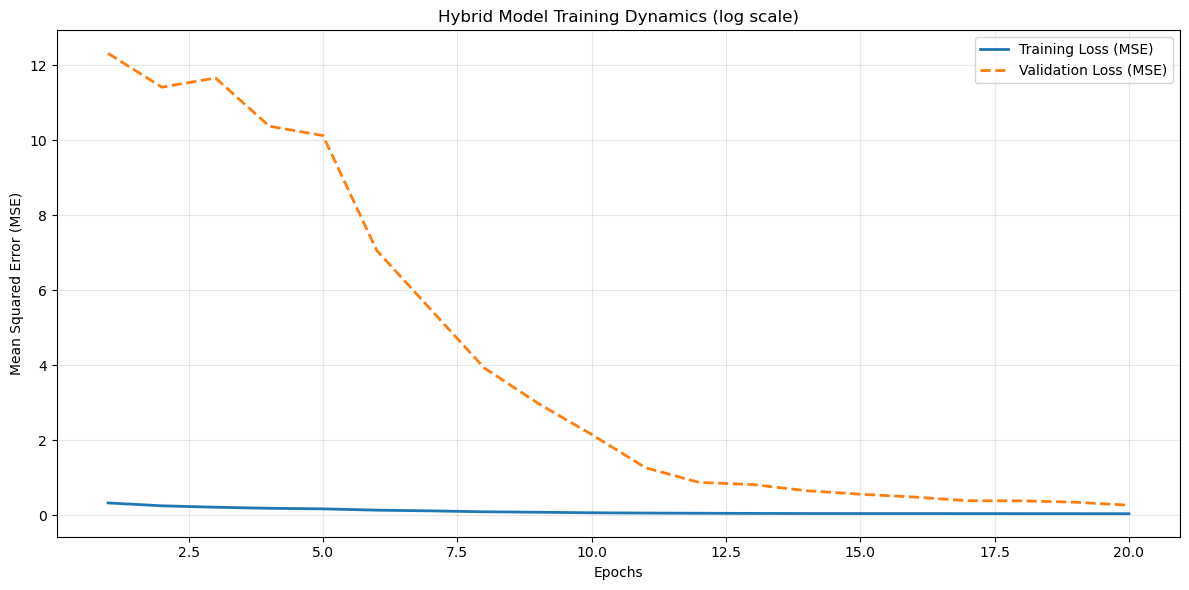

In [52]:
#------Block 5-----
# Visualization

def plot_training_history(history):
    """
    Plots the training and validation loss curves to evaluate model performance.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss, label='Training Loss (MSE)', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss (MSE)', linestyle='--', linewidth=2)
    
    plt.title('Hybrid Model Training Dynamics (log scale)')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize the results
if 'history' in locals():
    plot_training_history(history)

Block 6: Loads the best saved model, predicts on the validation set, calculates R², and plots the Actual vs. Predicted graph (Model Evaluation)

Loading best performing model...
Generating predictions on validation set...


c:\Users\navya\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


405/405 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step

--- FINAL HYBRID MODEL PERFORMANCE ---
R² Score: 0.0585
RMSE:     343,792.90


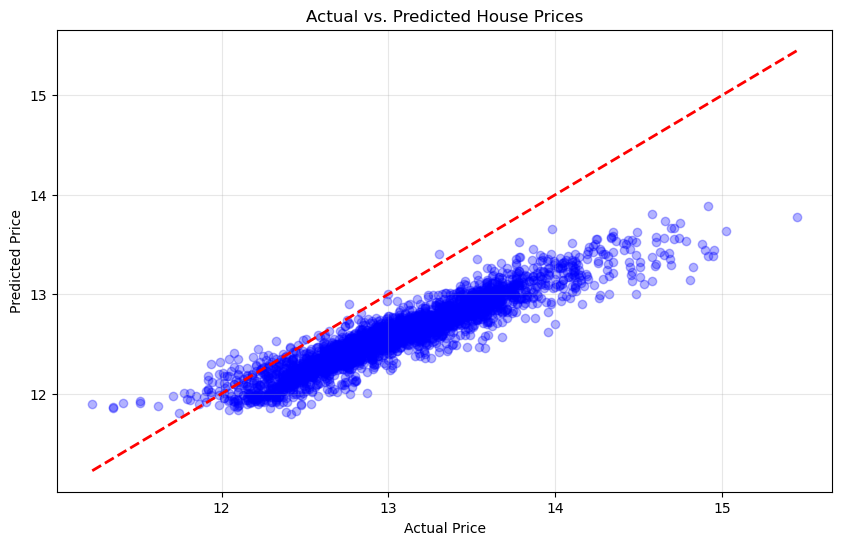

In [53]:
# --- BLOCK 6: MODEL EVALUATION ---
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score, mean_squared_error

print("Loading best performing model...")
# Load the model state with the lowest validation loss from training
best_model = load_model('best_hybrid_model.keras')

# 1. Generate Predictions
# Note: We use the validation generator to ensure data preprocessing matches training exactly
print("Generating predictions on validation set...")
val_predictions = best_model.predict(val_gen, verbose=1).flatten()

# 2. Align Ground Truth Data
# The generator processes data in full batches. We must align the actual labels 
# to match the number of predictions generated (dropping any final partial batch).
y_val_actual = val_gen.df[val_gen.y_col].values[:len(val_predictions)]

# 3. Calculate Metrics
r2 = r2_score(np.expm1(y_val_actual), np.expm1(val_predictions))
rmse = np.sqrt(mean_squared_error(np.expm1(y_val_actual), np.expm1(val_predictions)))

print("\n--- FINAL HYBRID MODEL PERFORMANCE ---")
print(f"R² Score: {r2:.4f}")
print(f"RMSE:     {rmse:,.2f}")

# 4. Visualization: Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_val_actual, val_predictions, alpha=0.3, color='blue')
plt.plot([y_val_actual.min(), y_val_actual.max()], [y_val_actual.min(), y_val_actual.max()], 'r--', lw=2)
plt.title('Actual vs. Predicted House Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True, alpha=0.3)
plt.show()

Block 7: Predicts prices for the unknown submission dataset and saves the final_submission_hybrid.csv file (Generate Final Submission)

In [ ]:
# --- BLOCK 7: GENERATE SUBMISSION FILE ---
filename = 'final_submission_hybrid.csv'

# Check if the file already exists
if os.path.exists(filename):
    print(f"Submission file '{filename}' already exists. Skipping prediction loop.")
    print("If you want to regenerate it, delete the file or rename it.")

else:
    print("Generating final submission predictions...")



    # 1. Feature Alignment
    train_features = [c for c in X_train.columns if c != 'price']
    X_submission_aligned = X_submission[train_features]

    # 2. Initialize Data Generator
    # We use batch_size=1 to ensure memory safety and that no rows are dropped.
    submission_gen = MultimodalDataGenerator(
        df=X_submission_aligned,
        x_col='id',
        y_col=None,
        image_dir=IMAGE_FOLDER,
        batch_size=1,        
        target_size=IMAGE_SIZE,
        shuffle=False  )     

    # 3. Prediction Loop
    # Iterate manually to predict one-by-one, avoiding RAM overload.
    all_predictions = []
    total_rows = len(submission_gen)

    for i in range(total_rows):
    # Fetch data batch (returns [image_data, tabular_data])
        batch_data = submission_gen[i]
    
        # Predict immediately (verbose=0 keeps output clean)
        pred = best_model.predict(batch_data, verbose=0).flatten()
        all_predictions.extend(pred)

    # 4. Create and Save Submission DataFrame
    submission_df = pd.DataFrame({
        'id': X_submission.index,
        'price': all_predictions
        })

    filename = 'final_submission_hybrid.csv'
    submission_df.to_csv(filename, index=False)

    print(f" Submission saved successfully: {filename}")
    print(f"Total Predictions: {len(submission_df)}")

Submission file 'final_submission_hybrid.csv' already exists. Skipping prediction loop.
If you want to regenerate it, delete the file or rename it.


Block 8: GRAD CAM EXPLAINABILITY

✅ Using Data Source with 3242 houses.

🔎 Analyzing House ID: 1338800280
📉 Image Contribution to Price: 0.0080%


C:\Users\navya\AppData\Local\Temp\ipykernel_9324\792161756.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")(np.arange(256))[:, :3]


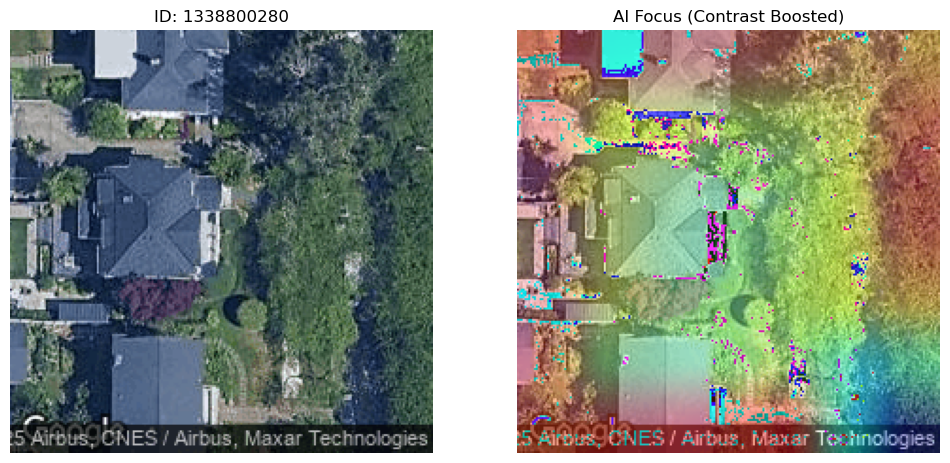

In [ ]:
# --- BLOCK 8: GRAD-CAM VISUALIZATION  ---
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

# 1. SETUP: Define Source Data
try:
    if 'val_df' in locals():
        data_source = val_df
        print(" Using 'val_df' for data lookup.")
    elif 'X_test' in locals():
        data_source = X_test
        print(" Using 'X_test' for data lookup.")
    else:
        raise ValueError("Could not find a dataframe (val_df, X_test).")
except Exception as e:
    print(f" Setup Error: {e}")

# 2. SELECT A RANDOM HOUSE
try:
    random_idx = np.random.choice(data_source.index)
    target_id = str(random_idx) 
    print(f"\n Explaining Random House ID: {target_id}")

    # 3. GET TABULAR DATA
    feature_cols = [c for c in data_source.columns if c != 'price']
    tab_data = data_source.loc[random_idx, feature_cols].values.astype('float32')
    tab_in = np.expand_dims(tab_data, axis=0)

    # 4. GET IMAGE DATA
    img_path = os.path.join("house_images", f"{target_id}.jpg")
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image file not found: {img_path}")

    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_in = np.expand_dims(img_array / 255.0, axis=0) 

    # 5. GENERATE HEATMAP 
    
    # A. Find the last convolutional layer (EfficientNet)
    try:
        last_conv_layer = hybrid_model.get_layer('efficientnetb0')
    except ValueError:
        # Fallback: Sometimes Keras names it 'functional_1' or similar
        # We search for the layer that has 4 dimensions (batch, height, width, channels)
        for layer in hybrid_model.layers:
            if len(layer.output_shape) == 4 and 'input' not in layer.name:
                last_conv_layer = layer
                break
    
    print(f" Peeking into layer: {last_conv_layer.name}")

    # B. Create the Explanation Model
    explanation_model = Model(inputs=hybrid_model.inputs, 
        outputs=[last_conv_layer.output, hybrid_model.output])

    # C. Calculate Gradients
    with tf.GradientTape() as tape:
        img_tensor = tf.cast(img_in, tf.float32)
        tab_tensor = tf.cast(tab_in, tf.float32)
        conv_out, price = explanation_model([img_tensor, tab_tensor], training=False)
        if isinstance(price, list): price = price[0]

    grads = tape.gradient(price, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = conv_out[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)

    # 6. CONTRAST FIX (For Lazy Models)
    if np.max(heatmap) < 1e-5:
        print("⚠️ Model ignored the image (Pure Tabular Decision).")
        heatmap = np.zeros_like(heatmap)
    else:
        heatmap = np.power(heatmap, 4) # Contrast Booster
        if np.max(heatmap) > 0: heatmap /= np.max(heatmap)

    # 7. VISUALIZE
    original = img_in[0] * 255.0
    
    # Overlay logic
    if np.max(heatmap) == 0:
        final = tf.keras.preprocessing.image.array_to_img(original)
    else:
        heatmap_uint8 = np.uint8(255 * heatmap)
        jet = cm.get_cmap("jet")(np.arange(256))[:, :3]
        jet_heatmap = jet[heatmap_uint8]
        jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap).resize((224, 224))
        final = np.array(jet_heatmap) * 0.4 + original
        final = tf.keras.preprocessing.image.array_to_img(final)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1); plt.imshow(original.astype('uint8')); plt.title(f"ID: {target_id}"); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(final); plt.title("AI Focus"); plt.axis('off')
    plt.show()

except Exception as e:
    print(f" Error: {e}")